##### Importing Libraries

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import datetime
import random as rn

import os
from sklearn.utils import resample

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##### Importing Dataset

In [2]:
bank_df = pd.read_csv(os.getcwd().replace("\\","/")+'/Dataset/'+'Bank-Telemarketing.csv')

##### Data Pre-processing 

In [3]:
# Looking for Duplicate Values
print('Before Removal : Duplicate values in the bank dataset are: ', bank_df.duplicated().sum())
bank_df.drop_duplicates(inplace=True)

print('After Removal : Duplicate values in the bank dataset are: ', bank_df.duplicated().sum())

# Looking for Null Values
print("Null Values :",bank_df.isnull().sum().sum())

# Looking for Class Imbalance
class_no=(bank_df.y.value_counts()[0])/(bank_df.y.value_counts().sum())*100
class_yes=(bank_df.y.value_counts()[1])/(bank_df.y.value_counts().sum())*100

print("NO Response :","%.2f" % class_no,"%")
print("YES Response :","%.2f" % class_yes,"%")

if bank_df.y.value_counts()[0] != bank_df.y.value_counts()[1]:
    print("\nClass is Imbalanced")
    
    bank_df_class_majority = bank_df[bank_df.y=='no'] 
    bank_df_class_minority = bank_df[bank_df.y=='yes']
    
    # Upsample of minority class
    bank_df_class_minority_upsampled = resample(bank_df_class_minority,
                                                replace = True,
                                                n_samples = bank_df_class_majority.shape[0])
    
    bank_df_balanced_data = pd.concat([bank_df_class_majority, bank_df_class_minority_upsampled])
    
    # Again Looking for Class Imbalance
    Nclass_no=(bank_df_balanced_data.y.value_counts()[0])/(bank_df_balanced_data.y.value_counts().sum())*100
    Nclass_yes=(bank_df_balanced_data.y.value_counts()[1])/(bank_df_balanced_data.y.value_counts().sum())*100
    print("NO Response :","%.2f" % Nclass_no,"%")
    print("YES Response :","%.2f" % Nclass_yes,"%")

    if bank_df_balanced_data.y.value_counts()[0] != bank_df_balanced_data.y.value_counts()[1]:
        print("\nClass is Imbalanced")
    else:
        print("\nClass is Balanced")    
    
else:
    print("\nClass is Balanced")
    
# Creating labels for Categorical Variables
bank_df_balanced_data.loan = bank_df_balanced_data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
bank_df_balanced_data.housing = bank_df_balanced_data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
bank_df_balanced_data.default = bank_df_balanced_data.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')

categorical_var = []

for col in bank_df_balanced_data.columns:
    if bank_df_balanced_data[col].dtypes=="O":
        categorical_var.append(col)
        
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in categorical_var:
    bank_df_balanced_data[i]= le.fit_transform(bank_df_balanced_data[i])

Before Removal : Duplicate values in the bank dataset are:  12
After Removal : Duplicate values in the bank dataset are:  0
Null Values : 0
NO Response : 88.73 %
YES Response : 11.27 %

Class is Imbalanced
NO Response : 50.00 %
YES Response : 50.00 %

Class is Balanced


##### Spliting Data

In [4]:
#Creating Independent and Depepndent Variables

X = bank_df_balanced_data.iloc[:,0:-1]  #independent columns
y = bank_df_balanced_data.iloc[:,-1]    #target column

#Scaling Independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2, random_state=0)

# Further splitting the training data into train and validation
feature_train, feature_val, label_train, label_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=0)

##### Creating Model

In [5]:
model = Sequential()

model.add(Dense(16, input_dim=20, activation='relu', name= 'input'))
model.add(Dense(32, activation='relu', name= 'hidden_1'))
model.add(Dense(32, activation='relu', name= 'hidden_2'))
model.add(Dense(64, activation='relu', name= 'hidden_3'))
model.add(Dense(64, activation='relu', name= 'hidden_4'))
model.add(Dense(128,activation='relu', name= 'hidden_5'))
model.add(Dense(128,activation='relu', name= 'hidden_6'))
model.add(Dense(256,activation='relu', name= 'hidden_7'))
model.add(Dense(256,activation='relu', name= 'hidden_8'))
model.add(Dense(512,activation='relu', name= 'hidden_9'))
model.add(Dense(512,activation='relu', name= 'hidden_10'))
model.add(Dense(1, input_dim=20, activation='sigmoid', name= 'output'))

opt = Adam(learning_rate= 0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics= ['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 16)                336       
                                                                 
 hidden_1 (Dense)            (None, 32)                544       
                                                                 
 hidden_2 (Dense)            (None, 32)                1056      
                                                                 
 hidden_3 (Dense)            (None, 64)                2112      
                                                                 
 hidden_4 (Dense)            (None, 64)                4160      
                                                                 
 hidden_5 (Dense)            (None, 128)               8320      
                                                                 
 hidden_6 (Dense)            (None, 128)               1

##### Training Model

In [6]:
training_results = model.fit(x=feature_train, 
                             y=label_train, 
                             verbose=1, 
                             batch_size=175, 
                             epochs=35 , 
                             validation_data= (feature_val,label_val), 
                             callbacks=[tensorboard_callback])

Epoch 1/35
301/301 [==============================] - 13s 31ms/step - loss: 0.3793 - accuracy: 0.8381 - val_loss: 0.3144 - val_accuracy: 0.8770
Epoch 2/35
301/301 [==============================] - 6s 19ms/step - loss: 0.3060 - accuracy: 0.8735 - val_loss: 0.2780 - val_accuracy: 0.8864
Epoch 3/35
301/301 [==============================] - 5s 18ms/step - loss: 0.2858 - accuracy: 0.8817 - val_loss: 0.2639 - val_accuracy: 0.8939
Epoch 4/35
301/301 [==============================] - 5s 18ms/step - loss: 0.2730 - accuracy: 0.8881 - val_loss: 0.2667 - val_accuracy: 0.8921
Epoch 5/35
301/301 [==============================] - 5s 16ms/step - loss: 0.2647 - accuracy: 0.8910 - val_loss: 0.2651 - val_accuracy: 0.8934
Epoch 6/35
301/301 [==============================] - 5s 18ms/step - loss: 0.2583 - accuracy: 0.8952 - val_loss: 0.2568 - val_accuracy: 0.9008
Epoch 7/35
301/301 [==============================] - 5s 18ms/step - loss: 0.2496 - accuracy: 0.9005 - val_loss: 0.2460 - val_accuracy: 0.904

In [7]:
# Visualizing on Tensorboard
%tensorboard --logdir logs/fit

##### Visualizing Training Results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


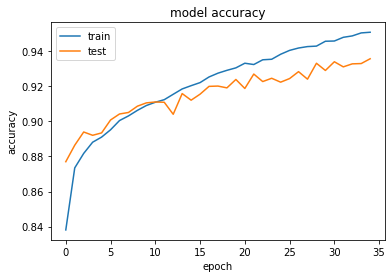

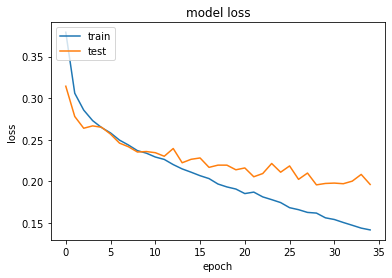

In [8]:
# list all data in history
print(training_results.history.keys())
#summarize history for accuracy
#plt.figure(figsize=(20,20))
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_results.history['loss'])
plt.plot(training_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Model Evaluation

In [9]:
results = model.evaluate(X_test, y_test, verbose=0)
print("Loss :",results[0])
print("Accuracy :",results[1])

Loss : 0.19544504582881927
Accuracy : 0.9387615323066711


##### Exporting Model

In [11]:
# Save the entire model as a SavedModel.
model.save(os.getcwd().replace("\\","/")+'/model/')

INFO:tensorflow:Assets written to: c:/Users/anura/Desktop/CIS_Final_Exam-1/BankApp/model/assets
